In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,Normalizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, r2_score
from sklearn.feature_selection import mutual_info_regression

import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

import pytz
import shap
import pickle

from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection

RANDOM_STATE = 42

# Perameters


In [2]:
node_id = '10004098'
dir_out = '../figures/spatial/'
dir_data = '../data/'

years = ['2019','2020'] ####
months = ['1','2','3','4','5','6','7','8','9','10','11','12']
days = np.array(range(1,31+1)).astype(str) #### np.array(range(1,31+1)).astype(str)
days = list(days)

hours = (np.array(range(0,24))).astype(str)
hours = list(hours)

bins = np.array(range(0,420+1)).astype(str)
bins = list(bins)
for i in range(len(bins)):
    bins[i] = 'Spectrum[' + bins[i] + ']'

wavelengths = np.array(range(360,780+1))#.astype(str)
#for i in range(len(wavelengths)):
#    wavelengths[i] = wavelengths[i] + 'nm'
#wavelengths = list(wavelengths)

# Read Data

In [77]:
# if data has been preprocessed before, run this directly
fn_data = dir_data + 'driving_' + node_id + '_NEXRAD_5km_landsat.csv'
df = pd.read_csv(fn_data, parse_dates=True, index_col = 'UTC')

# iwant = df.index.date < datetime.date(2020, 3, 1)
# df = df[iwant]

surface_reflectances_rename =  {'Surface Reflectance Band 1' : 'Surface Reflectance 435-451 nm', # 435-451nm, Ultra Blue
                                'Surface Reflectance Band 2' : 'Surface Reflectance 452-512 nm', # 452-512nm, Blue
                                'Surface Reflectance Band 3' : 'Surface Reflectance 533-590 nm', # 533-590nm, Greeen
                                'Surface Reflectance Band 4' : 'Surface Reflectance 636-673 nm'} # 636-673nm, Readm

surface_reflectances = ['Surface Reflectance 435-451 nm', # 435-451nm, Ultra Blue
                        'Surface Reflectance 452-512 nm', # 452-512nm, Blue
                        'Surface Reflectance 533-590 nm', # 533-590nm, Greeen
                        'Surface Reflectance 636-673 nm'] # 636-673nm, Red

df = df.rename(columns=surface_reflectances_rename)
df.head()

,Illuminance,360nm,361nm,362nm,363nm,364nm,365nm,366nm,367nm,368nm,...,Reflectivity Level_10km South_5km,Reflectivity Level_10km South_5km West_5km,Reflectivity Level_10km West_5km,Reflectivity Level_10km North_5km West_5km,LocalTime,date,Surface Reflectance 435-451 nm,Surface Reflectance 452-512 nm,Surface Reflectance 533-590 nm,Surface Reflectance 636-673 nm
UTC,,,,,,,,,,,,,,,,,,,,,
2020-01-08 16:43:50,2345.220551,0.032529,0.032651,0.033183,0.033997,0.034946,0.035627,0.036239,0.036761,0.037158,...,NaN,NaN,NaN,NaN,2020-01-08 10:43:50,2020/01/08,582,656,925,1029
2020-01-08 16:44:00,2385.540894,0.033112,0.033226,0.033758,0.034580,0.035541,0.036231,0.036851,0.037380,0.037782,...,NaN,NaN,NaN,NaN,2020-01-08 10:44:00,2020/01/08,974,1096,1371,1635
2020-01-08 16:46:40,3521.045288,0.036604,0.036802,0.037441,0.038386,0.039475,0.040252,0.040949,0.041550,0.042018,...,NaN,NaN,NaN,NaN,2020-01-08 10:46:40,2020/01/08,907,1043,1421,1676
2020-01-08 16:46:50,4220.051209,0.044110,0.044308,0.045068,0.046215,0.047553,0.048541,0.049440,0.050220,0.050827,...,NaN,NaN,NaN,NaN,2020-01-08 10:46:50,2020/01/08,1042,1167,1566,1761
2020-01-08 16:47:00,4105.486389,0.043972,0.044196,0.044981,0.046150,0.047503,0.048477,0.049356,0.050115,0.050708,...,NaN,NaN,NaN,NaN,2020-01-08 10:47:00,2020/01/08,841,925,1185,1359


In [79]:
# grid parameters
step = 100 # grid resolution (meter) in x-y plane

z_0, delta_z = 0, 10000
num_z = int(delta_z // 1000) + 1

delta_y , delta_x  = 1000, 1000 # neighbor distance
delta_iy, delta_ix = int(delta_y / step), int(delta_x / step)

# neighbor parameters
neighbor = {'': (0, 0)}
km_max = 5
for i in range(1,km_max+1): # distance (km)
    neighbor['North_%dkm'          %(i  )] = ( i*delta_iy,           0)
    neighbor['North_%dkm East_%dkm'%(i,i)] = ( i*delta_iy,  i*delta_ix)
    neighbor[           'East_%dkm'%(  i)] = (          0,  i*delta_ix)
    neighbor['South_%dkm East_%dkm'%(i,i)] = (-i*delta_iy,  i*delta_ix)
    neighbor['South_%dkm'          %(i  )] = (-i*delta_iy,           0)
    neighbor['South_%dkm West_%dkm'%(i,i)] = (-i*delta_iy, -i*delta_ix)
    neighbor[           'West_%dkm'%(  i)] = (          0, -i*delta_ix)
    neighbor['North_%dkm West_%dkm'%(i,i)] = ( i*delta_iy, -i*delta_ix)
    

In [83]:
features0 = ['altitude', 'Zenith', 'Azimuth', 'Sun Distance']
# features0 = ['Zenith', 'Sun Distance']

features = features0.copy()
reflectivities = []
for iz in range(num_z):
    for direction in neighbor:
        var = 'Reflectivity Level_%dkm' % (iz)
        if direction:
            var += ' ' + direction
        reflectivities.append(var)

features += reflectivities

features += surface_reflectances
features = np.array(features)

num_features = len(features)
print(num_features)

# targets =np.array([str(wavelength) + 'nm' for wavelength in wavelengths]) # skip Illuminance, keep Wavelengths
targets = ['Illuminance']


459


In [84]:
# try to apply exp on the reflectivities
# since L_Z=10 log10(Z/Z_0) in dbz
# so (Z/Z_0) = 10^(L_z/10)
df[reflectivities] = (10**(df[reflectivities]/10)).fillna(0)

In [ ]:
iwant = df.index.date < datetime.date(2020, 4, 1)

In [125]:
X = df[iwant][features]
Y = df[iwant][targets] # model and scaler use multi output

In [403]:
# def showCorr(cols):
#     size = len(cols)*0.8
#     fig = plt.figure(figsize=(size, size))
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(df[cols].corr(), cmap='RdBu')
#     cax.set_clim(-1, 1);
#     #plt.title('Correlation Matrix\n\n\n')
#     fig.colorbar(cax)
#     ax.set_xticklabels(np.append([""],cols), rotation=45, ha="left")
#     ax.set_yticklabels(np.append([""],cols))
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
#     plt.show()

In [507]:
# showCorr(np.append(features, targets[0]))

In [126]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


In [448]:
# # scale the 1st time
# scaler_x = StandardScaler()
# X0_train_scaled = scaler_x.fit_transform(X_train[features0])
# X0_test_scaled = scaler_x.transform(X_test[features0])

# # to DF
# X0_train_scaled = pd.DataFrame(X0_train_scaled, columns=features0, index = X_train.index)
# X0_test_scaled = pd.DataFrame(X0_test_scaled, columns=features0, index = X_test.index)

In [449]:
# # PCA on the features0
# features0_DR = ['PC0 ' + str(i) for i in range(len(features0))]


# pca0 = PCA(n_components=len(features0), random_state = RANDOM_STATE)
# X0_train_scaled_DR = pca0.fit_transform(X0_train_scaled)
# X0_test_scaled_DR = pca0.transform(X0_test_scaled)

# # to DF
# X0_train_scaled_DR = pd.DataFrame(X0_train_scaled_DR, columns=features0_DR, index = X_train.index)
# X0_test_scaled_DR = pd.DataFrame(X0_test_scaled_DR, columns=features0_DR, index = X_test.index)

# print(np.cumsum(pca0.explained_variance_)/np.sum(pca0.explained_variance_))

[0.45736656 0.72198317 0.88563153 1.        ]


In [450]:
# # try PCA on the NEXRAD reflectivities data
# pca1 = PCA(n_components=len(reflectivities), random_state = RANDOM_STATE)
# X_temp = pca1.fit_transform(X_train[reflectivities])
# print(np.cumsum(pca1.explained_variance_)/np.sum(pca1.explained_variance_))

[0.81262876 0.90104444 0.93772781 0.96165848 0.97537663 0.98208302
 0.98695509 0.99044422 0.99226595 0.993728   0.99477918 0.99563344
 0.99632555 0.99688013 0.99727583 0.99761088 0.99789791 0.99809099
 0.99825724 0.99840239 0.99853488 0.99864386 0.99875019 0.99885033
 0.99894402 0.99902977 0.99910659 0.99917383 0.99923293 0.99928576
 0.99933594 0.99938078 0.99942388 0.99946548 0.99949675 0.99952572
 0.9995543  0.99958022 0.99960495 0.99962786 0.99964942 0.99966903
 0.99968808 0.99970482 0.9997206  0.99973497 0.99974838 0.9997611
 0.99977325 0.99978522 0.99979602 0.99980601 0.99981555 0.99982419
 0.99983228 0.99983987 0.99984712 0.99985395 0.9998606  0.99986687
 0.99987252 0.99987809 0.99988336 0.99988827 0.99989296 0.99989759
 0.99990194 0.99990598 0.99990979 0.99991346 0.99991677 0.99992005
 0.99992315 0.99992615 0.99992895 0.99993163 0.99993412 0.99993657
 0.99993887 0.99994114 0.99994335 0.9999455  0.99994753 0.99994946
 0.99995136 0.99995316 0.99995489 0.99995657 0.99995818 0.99995

In [451]:
# # PCA on the NEXRAD reflectivities data
# n_components = 8 # 54 # 53 # 17 # num_features
# # reflectivities_DR = ['PC ' + str(i) for i in range(n_components)]
# # features_DR = np.append(features0, reflectivities_DR)
# reflectivities_DR = ['PC1 ' + str(i) for i in range(n_components)]

# DR = 'PCA'
# Cluster = 'None'
# pca1 = PCA(n_components=n_components, random_state = RANDOM_STATE)


# # X_train_DR = X_train[features0].copy()
# # X_train_DR[reflectivities_DR] = pca.fit_transform(X_train.loc[:,reflectivities])

# # X_test_DR = X_test[features0].copy()
# # X_test_DR[reflectivities_DR] = pca.transform(X_test.loc[:,reflectivities])

# X_train_reflectivities_DR = pca1.fit_transform(X_train[reflectivities])
# X_test_reflectivities_DR = pca1.transform(X_test[reflectivities])

# # print(pca.explained_variance_)

# # save pca model
# dir_DR = '../models/spatial/'
# if not os.path.exists(dir_DR):
#     os.mkdir(dir_DR)

# fn_DR = dir_DR + DR + '.sav'
# pickle.dump(pca1, open(fn_DR, 'wb'))

In [454]:
X_train_scaled_DR = X0_train_scaled_DR.copy()
X_train_scaled_DR[reflectivities_DR] = X_train_reflectivities_DR

X_test_scaled_DR = X0_test_scaled_DR.copy()
X_test_scaled_DR[reflectivities_DR] = X_test_reflectivities_DR


In [ ]:
# scaler_x = StandardScaler()
# X_train_scaled = scaler_x.fit_transform(X_train)
# X_test_scaled = scaler_x.transform(X_test)

# scaler_y = StandardScaler()
# Y_train_scaled = scaler_y.fit_transform(Y_train)
# Y_test_scaled = scaler_y.transform(Y_test)


In [12]:
# # scale the data again before NN
# scaler_x2 = StandardScaler()
# X_train_scaled_DR_scaled = scaler_x2.fit_transform(X_train_scaled_DR)
# X_test_scaled_DR_scaled = scaler_x2.transform(X_test_scaled_DR)

# Model Trainning

In [87]:
import lightgbm as lgb
import warnings
from sklearn.model_selection import RandomizedSearchCV

DR = ''

In [ ]:
# RandomizedSearchCV
rs_params = {
#     'boosting_type': ['gbdt'], # default = 'gbdt'
    'num_leaves': range(2, 160), # default = 31, Maximum tree leaves for base learners
    'max_depth' : [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9], # default = -1, Maximum tree depth for base learners
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4], # default = 0.1
    'n_estimators': range(10, 200, 10), # default = 100, Number of boosted trees
#     'subsample_for_bin': [200000], # default = 200000
    'objective' : ['regression'], # ‘regression’ for LGBMRegressor, ‘binary’ or ‘multiclass’ for LGBMClassifier
#     'class_weight': ['balanced'], # default = None, for multi-class
#     'is_unbalance': [True], # default = False, for binary
#     'min_split_gain' : [0.], # default=0.
#     'min_child_weight' : [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4], # default=1e-3
#     'min_child_samples': range(1, 500), # default=20
    'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # default=1.
#     'subsample_freq': [0], # default=0
    'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # default=1.
    'reg_alpha': [0, 1e-1, 0.5, 1, 2, 5, 7, 10, 50, 100], # default=0.  L1 regularization
    'reg_lambda': [0, 1e-1, 0.5, 1, 5, 10, 20, 50, 100], # default=0.  L2 regularization
    'random_state' : [RANDOM_STATE], # default=None
#     'n_jobs': [-1], # default=-1
    'silent': [True], # default=True
#     'importance_type': ['split'], # default='split', or 'gain'
}

start_time = time.time()
# Initialize a RandomizedSearchCV object using 5-fold CV-
rs_cv = RandomizedSearchCV(estimator = lgb.LGBMRegressor(random_state = RANDOM_STATE), 
                           param_distributions = rs_params,
#                            scoring= '', # 'f1' is better than 'roc_auc' for imbalanced data
                           refit = True,
                           verbose = True,
                           cv = 2,
                           n_jobs = -1,
                           n_iter = 1000,
                          )
fit_params = {"early_stopping_rounds":30, 
              "eval_metric" : 'mse', #
              "eval_set" : [(X_test, Y_test.values[:,0])],
              'eval_names': ['valid'],
              'verbose': 100,
              'categorical_feature': 'auto'
             }

# Train on training data
warnings.filterwarnings("ignore")
# rs_cv.fit(X_train_scaled_DR_scaled, Y_train_scaled, **fit_params)
rs_cv.fit(X_train, Y_train.values[:,0], **fit_params)

print(rs_cv.best_params_)
print(rs_cv.best_score_)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 2 folds for each of 1000 candidates, totalling 2000 fits


In [90]:
rs_cv.best_params_

{'subsample': 0.4,
 'silent': True,
 'reg_lambda': 100,
 'reg_alpha': 0,
 'random_state': 42,
 'objective': 'regression',
 'num_leaves': 70,
 'n_estimators': 130,
 'max_depth': -1,
 'learning_rate': 0.3,
 'colsample_bytree': 1.0}

In [127]:
# Fit the Model with Optimized Hyper-Parameters
# param = {
#     'num_leaves': 128, # default = 31, Maximum tree leaves for base learners
#     'max_depth' : -1, # default = -1, Maximum tree depth for base learners
#     'learning_rate': 0.05, # default = 0.1
#     'n_estimators': 140, # default = 100, Number of boosted trees
# #     'subsample_for_bin': 200000, # default = 200000
#     'objective' : 'regression', # ‘regression’ for LGBMRegressor, ‘binary’ or ‘multiclass’ for LGBMClassifier
# #     'class_weight': 'balanced', # default = None, for multi-class
# #     'min_child_weight' : 100., # default=1e-3
# #     'min_child_samples': 467, # default=20
#     'subsample': 1.0, # default=1.
#     'colsample_bytree': 0.9, # default=1.
#     'reg_alpha': 50, # default=0.  L1 regularization
#     'reg_lambda': 0, # default=0.  L2 regularization
#     'random_state' : RANDOM_STATE, # default=None
#     'silent': True, # default=True
# }

param = {
    'subsample': 0.4,
    'silent': True,
    'reg_lambda': 100,
    'reg_alpha': 0,
    'random_state': 42,
    'objective': 'regression',
    'num_leaves': 70,
    'n_estimators': 130,
    'max_depth': -1,
    'learning_rate': 0.3,
    'colsample_bytree': 1.0
}

# structure   = '_' + DR + str(n_components) \
structure   = '_' + 'ne' + str(param['n_estimators'])\
            + '_' + 'de' + str(param['max_depth'])\
            + '_' + 'nl' + str(param['num_leaves'])\
            + '_' + 'sr' + str(param['subsample'])\
            + '_' + 'fr' + str(param['colsample_bytree'])\
            + '_' + 'l1_' + str(param['reg_alpha'])\
            + '_' + 'l2_' + str(param['reg_lambda'])\


model = lgb.LGBMRegressor(**param)
fit_params = {"early_stopping_rounds": 100, 
              "eval_metric": 'l2', # l2 is mean_squared_error
              "eval_set": [(X_test, Y_test)],
              'eval_names': ['valid'],
              'verbose': 100,
              'categorical_feature': 'auto', # default='auto'
             }

warnings.filterwarnings("ignore")
# model.fit(X_train_scaled_DR_scaled, Y_train_scaled)#, **fit_params)
model.fit(X_train, Y_train, **fit_params)

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 1.15435e+06
Did not meet early stopping. Best iteration is:
[130]	valid's l2: 1.09371e+06


LGBMRegressor(learning_rate=0.3, n_estimators=130, num_leaves=70,
              objective='regression', random_state=42, reg_alpha=0,
              reg_lambda=100, subsample=0.4)

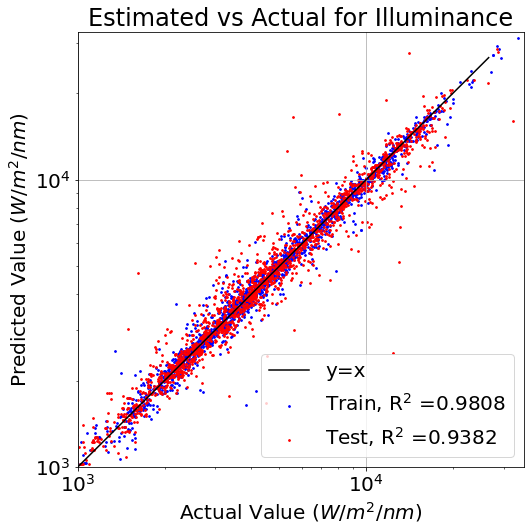

In [128]:
from sklearn.metrics import r2_score

# Y_train_pred = scaler_y.inverse_transform(
#                     model.predict( X_train_scaled_DR_scaled )
#                     ) # for train
Y_train_pred = model.predict( X_train)#[reflectivities_DR] )

# Y_train_pred = regr.predict( X_train_scaled_DR_scaled ) # for train
train_score = r2_score(Y_train, Y_train_pred)

# Y_test_pred = scaler_y.inverse_transform(
#                     model.predict( X_test_scaled_DR_scaled )
#                     )# for test
Y_test_pred = model.predict( X_test)#[reflectivities_DR] )

# Y_test_pred = regr.predict( X_test_scaled_DR_scaled )# for test
test_score = r2_score(Y_test, Y_test_pred)

# flatten
Y_train_flatten = Y_train.values.flatten()
Y_train_pred_flatten = Y_train_pred.flatten()

Y_test_flatten = Y_test.values.flatten()
Y_test_pred_flatten = Y_test_pred.flatten()

Y_min = 0 # np.min(Y_train_flatten)
Y_max = np.mean(Y_train_flatten) + 5*np.std(Y_train_flatten)

y_line = np.linspace(Y_min,Y_max,100)

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')

id_train = np.random.choice(len(Y_train_flatten), 2000, replace = False)
plt.scatter(Y_train_flatten[id_train], Y_train_pred_flatten[id_train], s=3, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])

id_test = np.random.choice(len(Y_test_flatten), 2000, replace = False)
plt.scatter(Y_test_flatten[id_test], Y_test_pred_flatten[id_test], s=3, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])

plt.xlim(10E2, )
plt.ylim(10E2, )

ax.set_title('Estimated vs Actual for Illuminance')# Spectrum')
ax.set_xlabel('Actual Value $(W/m^2/nm)$')
ax.set_ylabel('Predicted Value $(W/m^2/nm)$')
plt.xscale('log')
plt.yscale('log')
plt.legend( loc='lower right')
plt.grid()
# plt.tight_layout()

if not os.path.exists(dir_out + 'Illuminance'):
    os.mkdir(dir_out + 'Illuminance')
# plt.savefig(dir_out + 'Illuminance' +'/MLP_performance_whole'+structure+'.png')



In [121]:
iwant = df.index.date < datetime.date(2020, 4, 1)

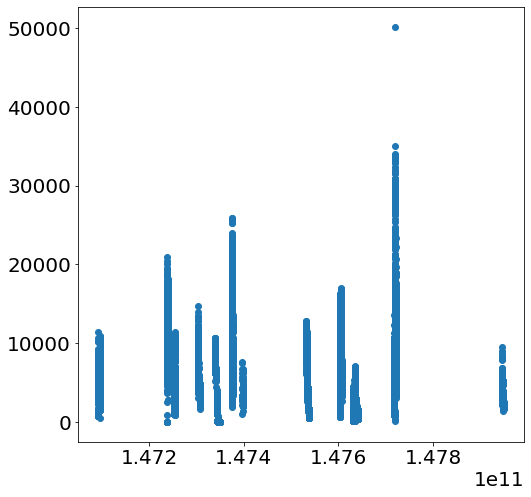

In [124]:
plt.scatter(df[iwant]['Sun Distance'], df[iwant]['Illuminance'])

In [113]:
# Create object that can calculate shap values
num_shap = 5000
start_time = time.time()
explainer = shap.TreeExplainer(model)

# Calculate shap_values
tree_shap_values = explainer.shap_values(X_train[:num_shap]) # 421 x num_shap x n_components
print("--- %s seconds ---" % (time.time() - start_time))

--- 7.669013023376465 seconds ---


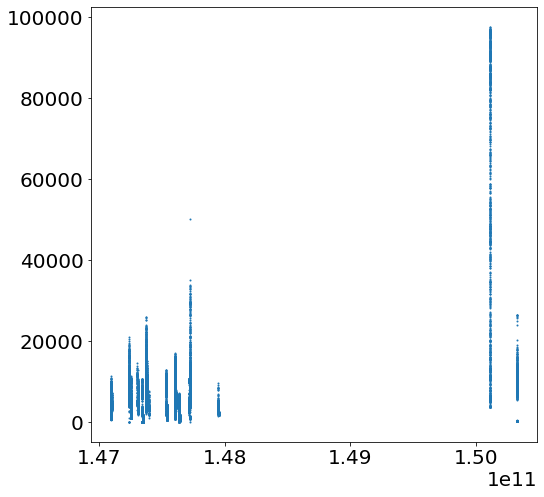

In [117]:
plt.scatter(df['Sun Distance'], df['Illuminance'], s = 1)

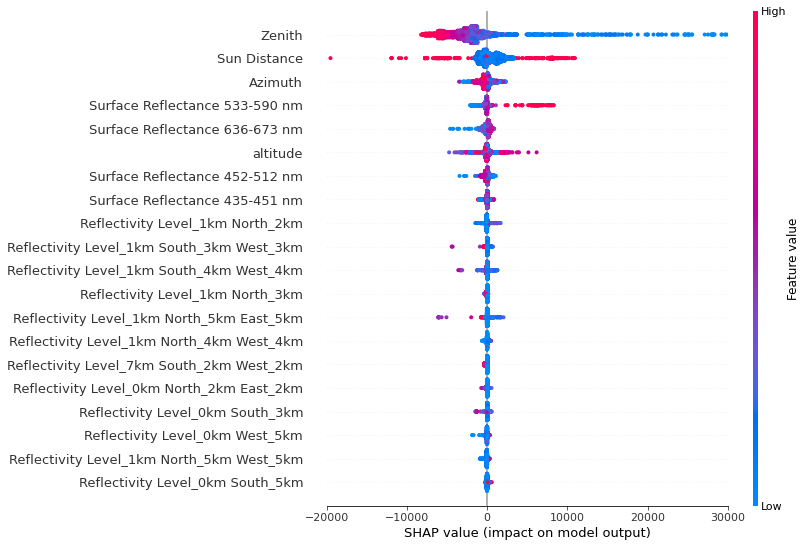

In [114]:
# plot
max_display = 20
# shap_values = pca.inverse_transform(shap_values_DR)
shap.summary_plot(tree_shap_values, X_train[:num_shap],
#                   feature_names = features_DR,
                  plot_size=(12,int(max_display/2.5)),#'auto'
                  max_display = max_display,
                  show=False
                 )
plt.xlim(-20000, 30000)
plt.tight_layout()
# plt.savefig(dir_out + 'Illuminance' + '/MLP_shapPCA_'+ 'Illuminance' +structure+'.png')

In [101]:
# importances of sun direction/distance and altitude
print(features0)
importances[:4]

['altitude', 'Zenith', 'Azimuth', 'Sun Distance']


array([ 197.17299311, 4970.22426315,  314.82609747, 1606.71725982])

In [102]:
# sum of importances of NEXRAD reflectivities
importances[4:4+len(reflectivities)].sum()

3173.4173085380817

In [103]:
# sum of importances of landsat surface reflectance
importances[-len(surface_reflectances):].sum()

728.0708240727256

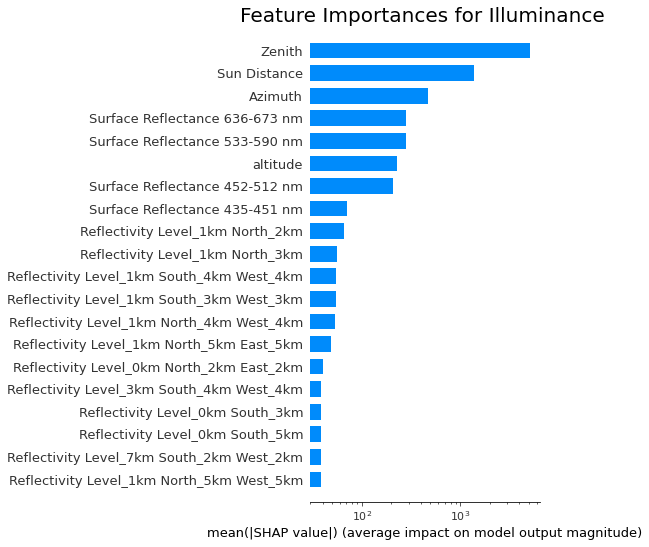

In [107]:
importances = np.mean(np.abs(tree_shap_values), axis = 0)
indices = np.argsort(importances)

# color positive/negative impact blue/red
# colormap = {1:'red',-1:'blue', 0:'grey'}
# impacts = np.array([])
# corrcoef = np.array([])
# sign = np.array([])
# for i in range(n_components):
#     impact_i = (shap_values_DR[:,i]*np.sign(X_train_scaled_DR_scaled[:num_shap,i] - X_train_scaled_DR_scaled[:num_shap, i].mean() )).mean()
#     impacts = np.append(impacts, impact_i)

#     corrcoef_i = np.corrcoef(X_train_scaled_DR_scaled[:,i], Y_train_pred.mean(axis = 1))[0,1]
#     corrcoef = np.append(corrcoef, corrcoef_i)
    
#     sign_i = np.sign(corrcoef_i)
#     sign = np.append(sign, sign_i)

# sign = sign[indices]
# impacts = impacts[indices]
# corrcoef = corrcoef[indices]

# # norm = mpl.colors.SymLogNorm(10, vmin=0, vmax=+0.05)
# norm = mpl.colors.Normalize(vmin=-1, vmax=+1)
# cmap = cm.get_cmap('RdBu_r')
# m = cm.ScalarMappable(norm=norm, cmap=cmap)

# color = [colormap[val] for val in sign]
# # color = [m.to_rgba(val) for val in impacts]
# # color = [m.to_rgba(val) for val in corrcoef]

shap.summary_plot(tree_shap_values, X_train[:num_shap],
                  feature_names = features,
                  plot_size=(8,max_display/2.5),#'auto'
#                   color = color,
                  max_display = max_display,
                  show = False,
                  plot_type = 'bar'
                 )

plt.xscale("log")
plt.title('Feature Importances for Illuminance ', fontsize = 20)
plt.tight_layout()
plt.savefig(dir_out + 'Illuminance' + '/MLP_'+'Importances_' + 'Illuminance' + structure +'.png')


In [493]:
print(features0)
importances[:4]

['altitude', 'Zenith', 'Azimuth', 'Sun Distance']


array([ 510.00930234, 4665.4367973 ,  595.53280061, 1715.65415173])

In [496]:
# total importances of reflctivities
importances[4:].sum()

2797.050749972459